localisation
- LN and WTE no longer be localised, because:
    - goal: where is domain knowledge stored?
    - LN: normalisaiton 목적이지 domain knowledge가 저장돼있다고 보기는 힘듦
    - WTE: word는 domain과 직접적인 연관을 갖고 있음
- model_editing(e.g. partial fine-tuning): LN, WTE는 반드시 tuned
- compression(e.g. pruning): LN, WTE는 대상에서 제외

- component unit: submodule, module

# Import libraries

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from os import listdir
import json
import math
import seaborn as sns

/Users/joon/opt/anaconda3/envs/m2d2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
device_id = "cpu"
cache_dir = "/Users/joon/.cache/huggingface"

# n_params per submodule and module

In [3]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to(device_id)   # TODO

dict_n_module_params = {}

for base_tup in list(base_model.named_parameters()):
    dict_n_module_params[base_tup[0]]= base_tup[1].numel()

with open('./data/dict_n_module_params_230627.json', 'w') as json_file:
    json.dump(dict_n_module_params, json_file) 

def parse_code_module(row):
    list_code = row.code.split(".")
    is_in_layer = row["code"].startswith("transformer.h")
    if is_in_layer:        
        row["l"] = int(list_code[2])
        row["m"] = list_code[3]
    else:
        row["m"] = list_code[1]
        if row["m"] == "ln_f": 
            row["l"] = int(99)
        elif row["m"] in ["wte", "wpe"]: 
            row['l'] = int(-1)
    row["w_or_b"] = list_code[-1]
    row["is_in_layer"] = is_in_layer
    if row["m"] in ["attn", "mlp"]:
        row["s"] = list_code[-2]
    else:
        row["s"] = row["m"]
    
    return row

df_n_module_params = pd.DataFrame.from_dict(dict_n_module_params, orient='index').reset_index()
df_n_module_params.columns = ['code', 'n_params']
df_n_module_params = df_n_module_params.apply(lambda row: parse_code_module(row), axis=1)

# is_localised = (df_n_module_params.m.isin(["attn", "mlp"])) & (df_n_module_params["is_in_layer"])
is_investigated = ~(df_n_module_params.m.isin(["wpe", "wte"])) 

df_n_module_params["is_investigated"] = is_investigated

# df_n_module_params

In [4]:
df_n_submodule_params_agg = df_n_module_params\
    .loc[:, ["m", "s", "n_params", "w_or_b", "is_investigated"]]\
    .groupby(["is_investigated", "m", "s", "w_or_b"])\
    .agg({"n_params": ["count", "first", ]}).unstack(-1)\
    .fillna(0).astype(int).drop(("n_params", "count", "bias"), axis=1)

df_n_submodule_params_agg

n_params                
                               count first          
w_or_b                        weight  bias    weight
is_investigated m    s                              
False           wpe  wpe           1     0    786432
                wte  wte           1     0  38597376
True            attn c_attn       12  2304   1769472
                     c_proj       12   768    589824
                ln_1 ln_1         12   768       768
                ln_2 ln_2         12   768       768
                ln_f ln_f          1   768       768
                mlp  c_fc         12  3072   2359296
                     c_proj       12   768   2359296

In [5]:
df_sub_cnt = df_n_submodule_params_agg\
    .drop(("n_params", "count", "weight"), axis=1)
# , ("n_params", "count", "weight")

- LayerNorm은 파라미터 수가 너무 적고, 역할을 생각해 볼 때 도메인 정보를 저장하고 있다고 보기는 힘듦


# Module

In [6]:
df_module_cnt = df_n_module_params.reset_index()\
    .loc[:, ["m", "s", "n_params", "w_or_b", "is_investigated"]]\
    .drop_duplicates()\
    .groupby(["is_investigated", "m", "w_or_b"])[["n_params"]].sum().unstack(-1)\
    .fillna(0).astype(int)

df_module_cnt = df_module_cnt.reset_index().drop("is_investigated", axis=1)
df_module_cnt.columns = ["module", "bias", "weight"]
df_module_cnt["total"] = df_module_cnt["bias"] + df_module_cnt["weight"] 

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/1268922046.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_module_cnt = df_module_cnt.reset_index().drop("is_investigated", axis=1)


## IN vs. ALL Rank Comparision

In [7]:
df_mod_diff_weights = pd.read_pickle("./data/df_avg_diff_weights_mod_230627.pkl")   # TODO
df_mod_diff_weights = df_mod_diff_weights.drop(["is_localised"], axis=1)
df_mod_diff_weights["is_investigated"] = ~df_mod_diff_weights["module"].isin(["wpe", "wte"])

In [8]:

df_modules = df_mod_diff_weights\
    .groupby(["is_in_layer", "is_investigated", "layer",  "component_id", "module"])[["diff", "scaled_diff"]].mean().reset_index()\
    .merge(df_module_cnt, on=["module"], how='left')


df_modules.loc[:, "v1_rank"] = df_modules["scaled_diff"].rank(ascending=False)

df_modules.loc[df_modules.is_investigated, "v2_rank"]\
    = df_modules.loc[df_modules.is_investigated]["scaled_diff"].rank(ascending=False)
df_modules["v2_rank"] = df_modules["v2_rank"].fillna(-1).astype(int)


In [9]:
df_modules["v1_accum_params"] = df_modules.sort_values("v1_rank")["total"].cumsum()
df_modules.loc[df_modules.is_investigated, "v2_accum_params"] = df_modules.loc[df_modules.is_investigated].sort_values("v2_rank")["total"].cumsum()
df_modules["v2_accum_params"] = df_modules["v2_accum_params"].fillna(-1).astype(int)

df_modules["v1_threshold"] = pd.cut(df_modules["v1_accum_params"], 4, labels=([25, 50, 75, 100])).astype(int)
df_modules.loc[df_modules.is_investigated, "v2_threshold"] = pd.cut(df_modules.loc[df_modules.is_investigated, "v2_accum_params"], 4, labels=([25, 50, 75, 100]))
df_modules["v2_threshold"] = df_modules["v2_threshold"].astype(float).fillna(-1).astype(int)

df_modules.v1_accum_params.max(), sum(p.numel() for p in base_model.parameters()), df_modules.v2_accum_params.max(), 124439808 - 786432 - 38597376 - 12 * (768 *4) -768 * 2

(124439808, 124439808, 85056000, 85017600)

In [10]:
df_mod_in_rank = df_mod_diff_weights[:]

df_mod_in_rank.loc[:, "v1_in_rank"] \
    = df_mod_in_rank.groupby(["dataset"])["diff"].rank(ascending=False)

df_mod_in_rank.loc[df_mod_in_rank.is_investigated, "v2_in_rank"] \
    = df_mod_in_rank.loc[df_mod_in_rank.is_investigated].groupby(["dataset"])["diff"].rank(ascending=False)
df_mod_in_rank["v2_in_rank"] = df_mod_in_rank["v2_in_rank"].fillna(-1).astype(int)

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/1568239806.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod_in_rank.loc[:, "v1_in_rank"] \
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/1568239806.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod_in_rank.loc[df_mod_in_rank.is_investigated, "v2_in_rank"] \
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/1568239806.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

### v1: all modules
- in_rank = rank on inidividual difference per model
- all_rank = rank on scaled difference

In [11]:
df_v1 = df_mod_in_rank.groupby(["layer", "component_id"])\
    .agg({"v1_in_rank": ["mean", "std"]})#.rename({"mean":"v2_in_rank_mean", "std":"v2_in_rank_std"}, axis=1)
df_v1.columns = ["v1_in_rank_mean", "v1_in_rank_std"]

df_modules.loc[:, ["layer", "component_id", "v1_threshold", "v1_rank"]].sort_values('v1_rank')\
    .rename({"v1_rank": "v1_all_rank"}, axis=1)\
    .merge(df_v1.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)

,component_id,v1_threshold,v1_all_rank,v1_in_rank_mean,v1_in_rank_std
0,h.11.ln_2,25,1.0,2.25,4.011497
1,h.0.ln_1,25,2.0,2.90,1.832456
2,ln_f,25,3.0,4.00,2.790963
3,h.11.mlp,25,4.0,8.45,6.492708
4,h.0.ln_2,25,5.0,10.05,6.589266
5,h.8.ln_1,25,6.0,14.45,12.318044
6,h.7.ln_1,25,7.0,15.85,15.065733
7,h.10.mlp,25,8.0,10.95,6.870800
8,h.9.ln_1,25,9.0,18.80,14.884114
9,h.10.ln_1,25,10.0,19.70,14.086574


In [12]:
df_mod_in_rank[["component_id", "v1_in_rank"]].merge(df_modules[["component_id", "v1_rank"]], on="component_id")[["v1_in_rank", "v1_rank"]].corr()

,v1_in_rank,v1_rank
v1_in_rank,1.000000,0.758552
v1_rank,0.758552,1.000000


### v2: modules except for LN, WTE

In [13]:
df_v2 = df_mod_in_rank.loc[df_mod_in_rank.is_investigated].groupby(["layer", "component_id"])\
    .agg({"v2_in_rank": ["mean", "std"]}).rename({"mean":"v2_in_rank_mean", "std":"v2_in_rank_std"}, axis=1)
df_v2.columns = ["v2_in_rank_mean", "v2_in_rank_std"]

df_modules.loc[df_modules.is_investigated, ["layer", "component_id", "v2_threshold", "v2_rank"]].sort_values('v2_rank')\
    .rename({"v2_rank": "v2_all_rank"}, axis=1)\
    .merge(df_v2.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)

,component_id,v2_threshold,v2_all_rank,v2_in_rank_mean,v2_in_rank_std
0,h.11.ln_2,25,1,2.25,4.011497
1,h.0.ln_1,25,2,2.90,1.832456
2,ln_f,25,3,4.00,2.790963
3,h.11.mlp,25,4,8.45,6.492708
4,h.0.ln_2,25,5,10.05,6.589266
5,h.8.ln_1,25,6,13.90,11.683997
6,h.7.ln_1,25,7,15.20,14.277697
7,h.10.mlp,25,8,10.95,6.870800
8,h.9.ln_1,25,9,18.05,14.091711
9,h.10.ln_1,25,10,19.05,13.445700


In [14]:
df_v2 = df_mod_in_rank.loc[df_mod_in_rank.is_investigated].groupby(["layer", "component_id"])\
    .agg({"v2_in_rank": ["mean", "std"]}).rename({"mean":"v2_in_rank_mean", "std":"v2_in_rank_std"}, axis=1)
df_v2.columns = ["v2_in_rank_mean", "v2_in_rank_std"]

df_modules.loc[df_modules.is_investigated, ["layer", "component_id", "v2_threshold", "v2_rank"]].sort_values('v2_rank')\
    .rename({"v2_rank": "v2_all_rank"}, axis=1)\
    .merge(df_v2.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)[["v2_in_rank_mean", "v2_all_rank"]].corr()

,v2_in_rank_mean,v2_all_rank
v2_in_rank_mean,1.00000,0.97693
v2_all_rank,0.97693,1.00000


In [15]:
n_total_params = sum(p.numel() for p in base_model.parameters())
df_modules.total.sum(), n_total_params, df_modules.total.sum() == n_total_params

(124439808, 124439808, True)

## modules by threshold

### v1: all modules

In [16]:
df_modules_agg = df_modules.groupby(["v1_threshold"]).agg({
    "component_id": [list],
    "total": ["count", "sum"],
})

df_modules_agg.columns = ["component_ids", "mod_cnt", "params"]
df_modules_agg["accum_params"] = df_modules_agg["params"].cumsum()
df_modules_agg["accum_prop_params"] = df_modules_agg["accum_params"] / n_total_params
df_modules_agg["component_ids"] = df_modules_agg["component_ids"].apply(lambda l: ", ".join(l))

In [17]:
df_modules_agg

,component_ids,mod_cnt,params,accum_params,accum_prop_params
v1_threshold,,,,,
25,"ln_f, h.0.ln_1, h.0.ln_2, h.5.ln_1, h.6.ln_1, ...",13,14182656,14182656,0.113972
50,"wte, h.0.attn, h.11.attn",3,43322112,57504768,0.462109
75,"h.2.attn, h.2.ln_1, h.3.attn, h.3.ln_1, h.4.at...",17,35436288,92941056,0.746876
100,"wpe, h.0.mlp, h.1.attn, h.1.ln_1, h.1.ln_2, h....",18,31498752,124439808,1.000000


### v2: modules except for LN, WTE

In [18]:
df_modules_agg = df_modules.groupby(["v2_threshold"]).agg({
    "component_id": [list],
    "total": ["count", "sum"],
})

df_modules_agg.columns = ["component_ids", "mod_cnt", "params"]
df_modules_agg["accum_params"] = df_modules_agg["params"].cumsum()
df_modules_agg["accum_prop_params"] = df_modules_agg["accum_params"] / n_total_params
df_modules_agg["component_ids"] = df_modules_agg["component_ids"].apply(lambda l: ", ".join(l))

In [19]:
df_modules_agg

,component_ids,mod_cnt,params,accum_params,accum_prop_params
v2_threshold,,,,,
-1,"wpe, wte",2,39383808,39383808,0.316489
25,"ln_f, h.0.attn, h.0.ln_1, h.0.ln_2, h.5.ln_1, ...",15,18907392,58291200,0.468429
50,"h.3.ln_1, h.4.attn, h.4.ln_1, h.7.attn, h.7.ml...",9,21259776,79550976,0.639273
75,"h.2.attn, h.2.ln_1, h.3.attn, h.4.mlp, h.5.att...",11,23622912,103173888,0.829107
100,"h.0.mlp, h.1.attn, h.1.ln_1, h.1.ln_2, h.1.mlp...",14,21265920,124439808,1.000000


## correlation between rankings

### v1: all modules

In [20]:
df_mod_in_rank[["component_id", "v1_in_rank"]]\
    .merge(df_modules[["component_id", "v1_rank"]], on="component_id")[["v1_in_rank", "v1_rank"]].corr()

,v1_in_rank,v1_rank
v1_in_rank,1.000000,0.758552
v1_rank,0.758552,1.000000


### v2: modules except for LN, WTE

In [21]:
df_mod_in_rank.loc[df_mod_in_rank.is_investigated, ["component_id", "v2_in_rank"]]\
    .merge(df_modules[["component_id", "v2_rank"]], on="component_id")[["v2_in_rank", "v2_rank"]].corr()

,v2_in_rank,v2_rank
v2_in_rank,1.000000,0.753699
v2_rank,0.753699,1.000000


In [22]:
l_temp = [39422208,
16529664,
14171904,
16531968,
16531968,
21252096]

[val / sum(l_temp) for val in l_temp]

[0.3167974029660991,
 0.13283260610623893,
 0.11388561448117952,
 0.1328511210817683,
 0.1328511210817683,
 0.17078213428294586]

## heatmap

### v1

In [23]:
list_layer_module_v1 = []
for layer in range(0, 12):
    for c in ["ln_1", "attn", "ln_2", "mlp"]:
        list_layer_module_v1.append(f"{layer}-{c}")

list_layer_module_v1 = ["-1-wte", "-1-wpe"] + list_layer_module_v1 + ["99-ln_f"]

#### all

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/3551704644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]


<Axes: xlabel='layer_module'>

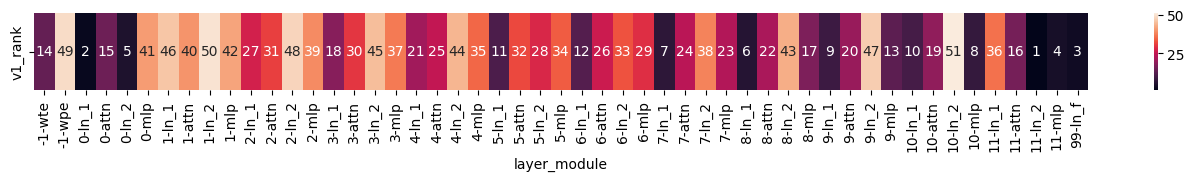

In [24]:
df_temp = df_modules[["module", "layer", "v1_rank"]]
df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]
plt.rcParams["figure.figsize"] = (17,1)
df_temp = df_temp.drop(["layer", "module"], axis=1).set_index("layer_module").loc[list_layer_module_v1].T
sns.heatmap(
    df_temp,
    annot=True
)


#### in

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/2187982464.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]


<Axes: xlabel='layer_module'>

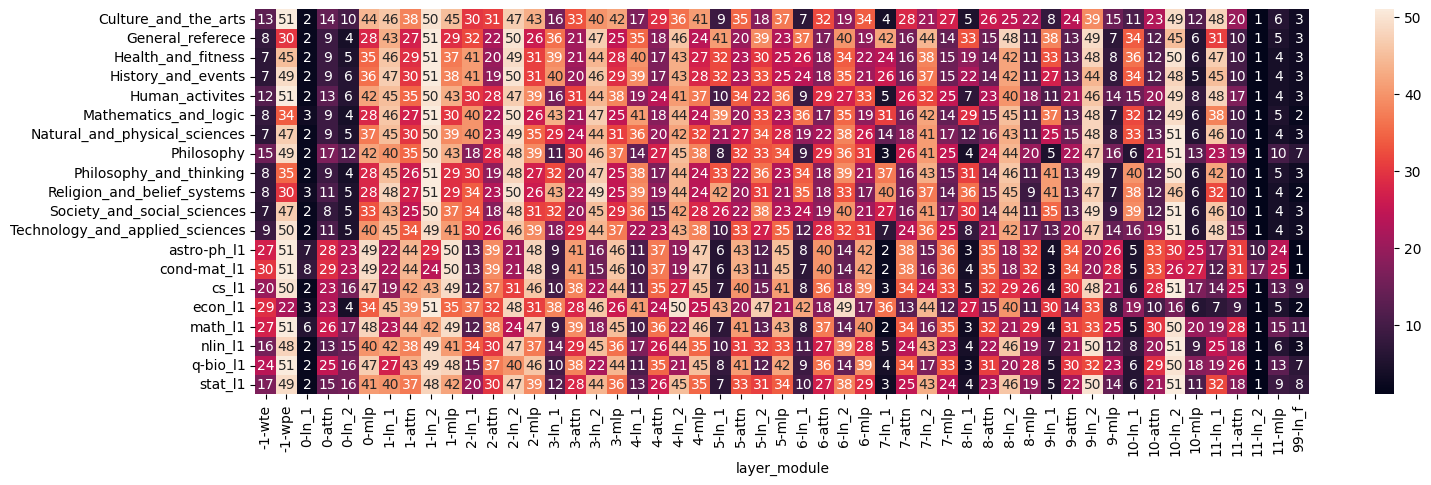

In [25]:
# temp = df_temp.T.index.tolist()
df_temp = df_mod_in_rank[["dataset", "module", "layer", "v1_in_rank"]]
df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]
df_temp= df_temp.drop(["layer", "module"], axis=1)
df_temp= df_temp.set_index(["layer_module", "dataset"]).unstack(-1)
df_temp = df_temp.loc[list_layer_module_v1]
df_temp.columns = [tup[1] for tup in df_temp.columns]

plt.rcParams["figure.figsize"] = (17,5)
sns.heatmap(
    df_temp.T,
    annot=True
)


### v2

In [26]:
list_layer_module_v2 = []
for layer in range(0, 12):
    for c in ["attn", "mlp"]:
        list_layer_module_v2.append(f"{layer}-{c}")

list_layer_module_v2 =list_layer_module_v2

#### all

<Axes: xlabel='layer_module'>

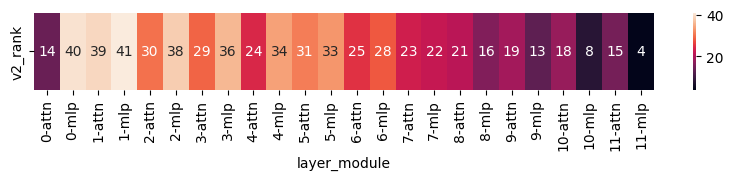

In [27]:
df_temp = df_modules.loc[df_modules.is_investigated][["module", "layer", "v2_rank"]]
df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]
plt.rcParams["figure.figsize"] = (10,1)
df_temp = df_temp.drop(["layer", "module"], axis=1).set_index("layer_module").loc[list_layer_module_v2].T
sns.heatmap(
    df_temp,
    annot=True
)


#### in

<Axes: xlabel='layer_module'>

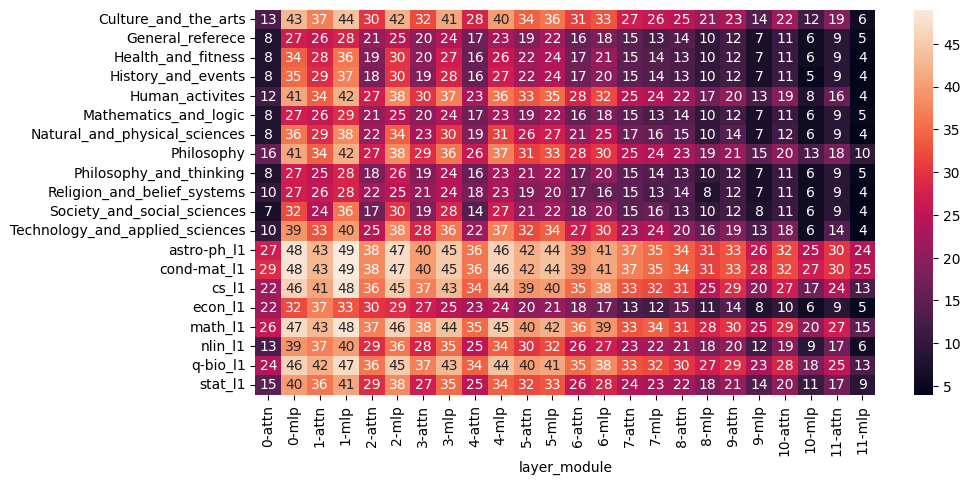

In [28]:
temp = df_temp.T.index.tolist()
df_temp = df_mod_in_rank.loc[df_mod_in_rank.is_investigated, ["dataset", "module", "layer", "v2_in_rank"]]
df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]
df_temp= df_temp.sort_values(["layer", "module"]).drop(["layer", "module"], axis=1)
df_temp= df_temp.set_index(["layer_module", "dataset"]).unstack(-1)

df_temp = df_temp.loc[list_layer_module_v2, :]
df_temp.columns = [tup[1] for tup in df_temp.columns]

plt.rcParams["figure.figsize"] = (10,5)
sns.heatmap(
    df_temp.T,
    annot=True
)


# Submodule

In [29]:
df_sub_cnt = df_sub_cnt.reset_index().drop("is_investigated", axis=1)
df_sub_cnt.columns = ["module", "submodule", "bias", "weight"]
df_sub_cnt["total"] = df_sub_cnt["bias"] + df_sub_cnt["weight"] 

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/2739633388.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_sub_cnt = df_sub_cnt.reset_index().drop("is_investigated", axis=1)


## IN vs. ALL Rank Comparision

In [57]:
df_sub_diff_weights = pd.read_pickle("./data/df_avg_diff_weights_sub_230627.pkl")

df_sub_diff_weights = df_sub_diff_weights.rename({"sub_module": "submodule"}, axis=1)
df_sub_diff_weights = df_sub_diff_weights.loc[df_sub_diff_weights.w_or_b == "weight"].drop(["w_or_b"], axis=1)
df_sub_diff_weights.submodule = df_sub_diff_weights.component_id.apply(lambda x: x.split(".")[-1])
is_in_layer = ~(df_sub_diff_weights.layer.isin([-1, 99]))
df_sub_diff_weights["is_in_layer"] = is_in_layer

is_investigated = ~(df_sub_diff_weights.module.isin(["wte", "wpe"]))
df_sub_diff_weights["is_investigated"] =  is_investigated

In [58]:
df_submodules = df_sub_diff_weights\
    .groupby(["is_investigated", "layer",  "component_id", "module", "submodule"])[["diff", "scaled_diff"]].mean().reset_index()\
    .merge(df_sub_cnt, on=["module", "submodule"], how='left')
    # .groupby(["is_in_layer", "is_investigated", "layer",  "component_id", "module"])[["diff", "scaled_diff"]].mean().reset_index()\

df_submodules.loc[:, "v1_rank"] = df_submodules["scaled_diff"].rank(ascending=False)

df_submodules.loc[df_submodules.is_investigated, "v2_rank"]\
    = df_submodules.loc[df_submodules.is_investigated]["scaled_diff"].rank(ascending=False)
df_submodules["v2_rank"] = df_submodules["v2_rank"].fillna(-1).astype(int)

In [59]:
df_submodules["v1_accum_params"] = df_submodules.sort_values("v1_rank")["total"].cumsum()
df_submodules.loc[df_submodules.is_investigated, "v2_accum_params"] = df_submodules.loc[df_submodules.is_investigated].sort_values("v2_rank")["total"].cumsum()
df_submodules["v2_accum_params"] = df_submodules["v2_accum_params"].fillna(-1).astype(int)

df_submodules["v1_threshold"] = pd.cut(df_submodules["v1_accum_params"], 4, labels=([25, 50, 75, 100])).astype(int)
df_submodules.loc[df_submodules.is_investigated, "v2_threshold"] = pd.cut(df_submodules.loc[df_submodules.is_investigated, "v2_accum_params"], 4, labels=([25, 50, 75, 100]))
df_submodules["v2_threshold"] = df_submodules["v2_threshold"].astype(float).fillna(-1).astype(int)


In [60]:
df_submodules.v1_accum_params.max(), sum(p.numel() for p in base_model.parameters()), df_submodules.v2_accum_params.max(), 124439808 - 786432 - 38597376 - 12 * (768 *4) -768 * 2


(124439808, 124439808, 85056000, 85017600)

In [61]:
df_sub_in_rank = df_sub_diff_weights[:]

df_sub_in_rank.loc[:, "v1_in_rank"] \
    = df_sub_in_rank.groupby(["dataset"])["diff"].rank(ascending=False)

df_sub_in_rank.loc[df_sub_in_rank.is_investigated, "v2_in_rank"] \
    = df_sub_in_rank.loc[df_sub_in_rank.is_investigated].groupby(["dataset"])["diff"].rank(ascending=False)
df_sub_in_rank["v2_in_rank"] = df_sub_in_rank["v2_in_rank"].fillna(-1).astype(int)

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/4187374775.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_in_rank.loc[:, "v1_in_rank"] \
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/4187374775.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_in_rank.loc[df_sub_in_rank.is_investigated, "v2_in_rank"] \
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/4187374775.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

### v1: all modules
- in_rank = rank on inidividual difference per model
- all_rank = rank on scaled difference

In [62]:
df_v1 = df_sub_in_rank.groupby(["layer", "component_id"])\
    .agg({"v1_in_rank": ["mean", "std"]})#.rename({"mean":"v2_in_rank_mean", "std":"v2_in_rank_std"}, axis=1)
df_v1.columns = ["v1_in_rank_mean", "v1_in_rank_std"]

df_submodules.loc[:, ["layer", "component_id", "v1_threshold", "v1_rank"]].sort_values('v1_rank')\
    .rename({"v1_rank": "v1_all_rank"}, axis=1)\
    .merge(df_v1.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)

,component_id,v1_threshold,v1_all_rank,v1_in_rank_mean,v1_in_rank_std
0,h.11.ln_2,25,1.0,2.25,4.011497
1,h.0.ln_1,25,2.0,2.90,1.832456
2,ln_f,25,3.0,4.25,2.899637
3,h.11.mlp.c_proj,25,4.0,7.30,5.822823
4,h.10.mlp.c_proj,25,5.0,9.80,6.152449
...,...,...,...,...,...
70,h.1.mlp.c_proj,100,71.0,66.90,6.935037
71,h.2.ln_2,100,72.0,62.30,18.487834
72,wpe,100,73.0,67.80,10.714476
73,h.1.ln_2,100,74.0,67.70,14.157386


In [63]:
df_submodules.loc[:, ["layer", "component_id", "v1_threshold", "v1_rank"]].sort_values('v1_rank')\
    .rename({"v1_rank": "v1_all_rank"}, axis=1)\
    .merge(df_v1.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1).head(38)

,component_id,v1_threshold,v1_all_rank,v1_in_rank_mean,v1_in_rank_std
0,h.11.ln_2,25,1.0,2.25,4.011497
1,h.0.ln_1,25,2.0,2.90,1.832456
2,ln_f,25,3.0,4.25,2.899637
3,h.11.mlp.c_proj,25,4.0,7.30,5.822823
4,h.10.mlp.c_proj,25,5.0,9.80,6.152449
5,h.0.ln_2,25,6.0,11.70,7.079251
6,h.8.ln_1,25,7.0,22.70,21.701564
7,h.7.ln_1,25,8.0,24.70,25.116780
8,h.0.attn.c_attn,25,9.0,13.20,8.319919
9,h.9.ln_1,25,10.0,27.90,24.565487


In [64]:
df_submodules.loc[:, ["layer", "component_id", "v1_threshold", "v1_rank"]].sort_values('v1_rank')\
    .rename({"v1_rank": "v1_all_rank"}, axis=1)\
    .merge(df_v1.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1).tail(37)

,component_id,v1_threshold,v1_all_rank,v1_in_rank_mean,v1_in_rank_std
38,h.3.attn.c_attn,75,39.0,32.15,6.619548
39,h.2.mlp.c_fc,75,40.0,38.65,6.714282
40,h.0.mlp.c_fc,75,41.0,39.15,5.584518
41,h.6.attn.c_attn,100,42.0,41.70,8.285053
42,h.5.attn.c_attn,100,43.0,43.30,8.053113
43,h.7.attn.c_proj,100,44.0,43.60,12.347597
44,h.2.ln_1,100,45.0,41.00,19.144877
45,h.5.ln_2,100,46.0,40.30,19.043164
46,h.7.mlp.c_proj,100,47.0,45.25,8.729110
47,h.6.attn.c_proj,100,48.0,46.65,10.569445


### v2: modules except for LN, WTE

In [65]:
df_v2 = df_sub_in_rank.loc[df_sub_in_rank.is_investigated].groupby(["layer", "component_id"])\
    .agg({"v2_in_rank": ["mean", "std"]})#.rename({"mean":"v2_in_rank_mean", "std":"v2_in_rank_std"}, axis=1)

df_v2.columns = ["v2_in_rank_mean", "v2_in_rank_std"]

# df_submodules.loc[df_submodules.is_investigated, ["layer", "component_id", "v2_threshold", "v2_rank"]].sort_values('v2_rank')\
#     .rename({"v2_rank": "v2_all_rank"}, axis=1)\
#     .merge(df_v2.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)

In [66]:
df_submodules.loc[df_submodules.is_investigated, ["layer", "component_id", "v2_threshold", "v2_rank"]].sort_values('v2_rank')\
    .rename({"v2_rank": "v2_all_rank"}, axis=1)\
    .merge(df_v2.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1).head(24)

,component_id,v2_threshold,v2_all_rank,v2_in_rank_mean,v2_in_rank_std
0,h.11.ln_2,25,1,2.25,4.011497
1,h.0.ln_1,25,2,2.90,1.832456
2,ln_f,25,3,4.25,2.899637
3,h.11.mlp.c_proj,25,4,7.30,5.822823
4,h.10.mlp.c_proj,25,5,9.80,6.152449
5,h.0.ln_2,25,6,11.70,7.079251
6,h.8.ln_1,25,7,22.15,21.059502
7,h.7.ln_1,25,8,24.05,24.332078
8,h.0.attn.c_attn,25,9,13.20,8.319919
9,h.9.ln_1,25,10,27.15,23.760372


In [67]:
df_submodules.loc[df_submodules.is_investigated, ["layer", "component_id", "v2_threshold", "v2_rank"]].sort_values('v2_rank')\
    .rename({"v2_rank": "v2_all_rank"}, axis=1)\
    .merge(df_v2.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1).tail(24)

,component_id,v2_threshold,v2_all_rank,v2_in_rank_mean,v2_in_rank_std
49,h.1.attn.c_attn,100,50,47.20,7.251860
50,h.11.ln_1,100,51,46.70,22.888977
51,h.7.ln_2,100,52,46.20,18.855685
52,h.6.mlp.c_proj,100,53,49.75,8.038558
53,h.5.attn.c_proj,100,54,51.50,9.230955
54,h.4.attn.c_proj,100,55,53.75,8.680741
55,h.5.mlp.c_proj,100,56,53.60,6.572671
56,h.8.ln_2,100,57,52.20,18.724035
57,h.4.ln_2,100,58,53.25,17.911699
58,h.0.attn.c_proj,100,59,55.95,7.250953


In [68]:
df_modules.total.sum(), n_total_params, df_submodules.total.sum() == n_total_params

(124439808, 124439808, True)

## modules by threshold

### v1: all modules
- in_rank = rank on inidividual difference per model
- all_rank = rank on scaled difference

In [69]:

df_submodules_agg = df_submodules.groupby(["v1_threshold"]).agg({
    "component_id": [list],
    "total": ["count", "sum"],
})

df_submodules_agg.columns = ["component_ids", "mod_cnt", "params"]
df_submodules_agg["prop"] = df_submodules_agg["params"] / n_total_params
df_submodules_agg["accum_params"] = df_submodules_agg["params"].cumsum()
df_submodules_agg["accum_prop_params"] = df_submodules_agg["accum_params"] / n_total_params
df_submodules_agg["component_ids"] = df_submodules_agg["component_ids"].apply(lambda l: ", ".join(l))
df_submodules_agg

,component_ids,mod_cnt,params,prop,accum_params,accum_prop_params
v1_threshold,,,,,,
25,"h.0.attn.c_attn, h.0.ln_1, h.0.ln_2, h.5.ln_1,...",18,14773248,0.118718,14773248,0.118718
50,"wte, h.3.ln_1, h.7.mlp.c_fc, h.8.mlp.c_fc, h.9...",6,46276608,0.371879,61049856,0.490597
75,"h.0.mlp.c_fc, h.2.attn.c_attn, h.2.mlp.c_fc, h...",17,31300608,0.251532,92350464,0.742130
100,"wpe, h.0.attn.c_proj, h.0.mlp.c_proj, h.1.attn...",34,32089344,0.257870,124439808,1.000000


### v2: modules except for LN, WTE

In [94]:
df_submodules_agg = df_submodules.groupby(["v2_threshold"]).agg({
    "component_id": [list],
    "total": ["count", "sum"],
})

df_submodules_agg.columns = ["component_ids", "mod_cnt", "params"]
df_submodules_agg["prop"] = df_submodules_agg["params"] / n_total_params
df_submodules_agg["accum_params"] = df_submodules_agg["params"].cumsum()
df_submodules_agg["accum_prop_params"] = df_submodules_agg["accum_params"] / n_total_params
df_submodules_agg["component_ids"] = df_submodules_agg["component_ids"].apply(lambda l: ", ".join(l))
df_submodules_agg

,component_ids,mod_cnt,params,prop,accum_params,accum_prop_params
v2_threshold,,,,,,
-1,"wpe, wte",2,39383808,0.316489,39383808,0.316489
25,"h.0.attn.c_attn, h.0.ln_1, h.0.ln_2, h.5.ln_1,...",21,20088576,0.161432,59472384,0.477921
50,"h.3.ln_1, h.4.attn.c_attn, h.4.ln_1, h.4.mlp.c...",13,21262080,0.170862,80734464,0.648783
75,"h.0.mlp.c_fc, h.1.mlp.c_fc, h.2.attn.c_attn, h...",15,21854208,0.175621,102588672,0.824404
100,"h.0.attn.c_proj, h.0.mlp.c_proj, h.1.attn.c_at...",24,21851136,0.175596,124439808,1.000000


In [97]:
df_sub_info = pd.read_pickle("./data/df_sub_info_230706.pkl")

In [98]:
df_sub_info

,code,is_in_layer,is_investigated,layer,module,submodule,trace_id,w_or_b,params
0,transformer.wte.weight,False,False,-1,wte,wte,transformer.wte,weight,38597376
1,transformer.wpe.weight,False,False,-1,wpe,wpe,transformer.wpe,weight,786432
2,transformer.h.0.ln_1.weight,True,True,0,ln_1,ln_1,transformer.h.0.ln_1,weight,768
3,transformer.h.0.ln_1.bias,True,True,0,ln_1,ln_1,transformer.h.0.ln_1,bias,768
4,transformer.h.0.attn.c_attn.weight,True,True,0,attn,c_attn,transformer.h.0.attn.c_attn,weight,1769472
...,...,...,...,...,...,...,...,...,...
143,transformer.h.11.mlp.c_fc.bias,True,True,11,mlp,c_fc,transformer.h.11.mlp.c_fc,bias,3072
144,transformer.h.11.mlp.c_proj.weight,True,True,11,mlp,c_proj,transformer.h.11.mlp.c_proj,weight,2359296
145,transformer.h.11.mlp.c_proj.bias,True,True,11,mlp,c_proj,transformer.h.11.mlp.c_proj,bias,768
146,transformer.ln_f.weight,False,True,99,ln_f,ln_f,transformer.ln_f,weight,768


In [105]:
# df_submodules_v2 = df_submodules[["component_id", "v2_threshold"]]
# df_submodules_v2["trace_id"] = "transformer." + df_submodules_v2["component_id"]


# df_sub_info = df_sub_info.merge(
#     df_submodules_v2.drop("component_id", axis=1)\
#         .rename({"v2_threshold": "threshold"}, axis=1), 
#     on=["trace_id"]
# )

# df_sub_info.to_pickle("./data/df_sub_info_230708.pkl")

## correlation between rankings

### v1: all modules

In [71]:
df_sub_in_rank[["component_id", "v1_in_rank"]]\
    .merge(df_submodules[["component_id", "v1_rank"]], on="component_id")[["v1_in_rank", "v1_rank"]].corr()

,v1_in_rank,v1_rank
v1_in_rank,1.000000,0.792516
v1_rank,0.792516,1.000000


In [72]:
df_sub_in_rank[["component_id", "v1_in_rank"]]\
    .merge(df_submodules[["component_id", "v1_rank"]], on="component_id")[["v1_in_rank", "v1_rank"]].corr(method='kendall')

,v1_in_rank,v1_rank
v1_in_rank,1.000000,0.638236
v1_rank,0.638236,1.000000


In [73]:
df_temp = df_sub_in_rank[["dataset", "component_id", "v1_in_rank"]]\
    .merge(df_submodules[["component_id", "v1_rank"]], on="component_id")#[["v2_in_rank", "v2_rank"]]

#######
# .corr(method='kendall')
df_temp = df_temp.groupby(["dataset"])[["v1_in_rank", "v1_rank"]].corr("kendall")
df_temp = df_temp.applymap(lambda x: None if x==1 else x)
df_temp.mean()

v1_in_rank    0.697982
v1_rank       0.697982
dtype: float64

### v2: modules except for LN, WTE

In [74]:
df_sub_in_rank.loc[df_sub_in_rank.is_investigated, ["component_id", "v2_in_rank"]]\
    .merge(df_submodules[["component_id", "v2_rank"]], on="component_id")[["v2_in_rank", "v2_rank"]].corr()

,v2_in_rank,v2_rank
v2_in_rank,1.00000,0.78831
v2_rank,0.78831,1.00000


In [75]:
df_sub_in_rank.loc[df_sub_in_rank.is_investigated, ["component_id", "v2_in_rank"]]\
    .merge(df_submodules[["component_id", "v2_rank"]], on="component_id")[["v2_in_rank", "v2_rank"]].corr(method='kendall')

,v2_in_rank,v2_rank
v2_in_rank,1.000000,0.633114
v2_rank,0.633114,1.000000


In [76]:
df_temp = df_sub_in_rank.loc[df_sub_in_rank.is_investigated][["dataset", "component_id", "v2_in_rank"]]\
    .merge(df_submodules[["component_id", "v2_rank"]], on="component_id")#[["v2_in_rank", "v2_rank"]]

#######
# .corr(method='kendall')
df_temp.groupby(["dataset"])[["v2_in_rank", "v2_rank"]].corr("kendall").mean()

v2_in_rank    0.846651
v2_rank       0.846651
dtype: float64

In [112]:
df_temp = df_sub_in_rank.loc[df_sub_in_rank.is_investigated][["dataset", "component_id", "v2_in_rank"]]\
    .merge(df_submodules[["component_id", "v2_rank"]], on="component_id")#[["v2_in_rank", "v2_rank"]]

#######
# .corr(method='kendall')
print(df_temp.groupby(["dataset"])[["v2_in_rank", "v2_rank"]].corr("kendall").mean()["v2_rank"])
print(df_temp.groupby(["dataset"])[["v2_in_rank", "v2_rank"]].corr("kendall").std()["v2_rank"])
print(df_temp.groupby(["dataset"])[["v2_in_rank", "v2_rank"]].corr().mean()["v2_rank"])
print(df_temp.groupby(["dataset"])[["v2_in_rank", "v2_rank"]].corr().std()["v2_rank"])


0.8466514459665143
0.18532149046845378
0.8941549426138466
0.15188690674164415


## heatmap

### v1

In [86]:
list_layer_submodule_v1 = []
for layer in range(0, 12):
    for c in ["ln_1", "attn.c_attn", "attn.c_proj", "ln_2", "mlp.c_fc", "mlp.c_proj"]:
        list_layer_submodule_v1.append(f"{layer}.{c}")

list_layer_submodule_v1 = ["-1.wte", "-1.wpe"] + list_layer_submodule_v1 + ["99.ln_f"]

#### all

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/2260184876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/2260184876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
/var/folders/_k/vry5m2bj1p7d9f

<Axes: xlabel='layer_submodule'>

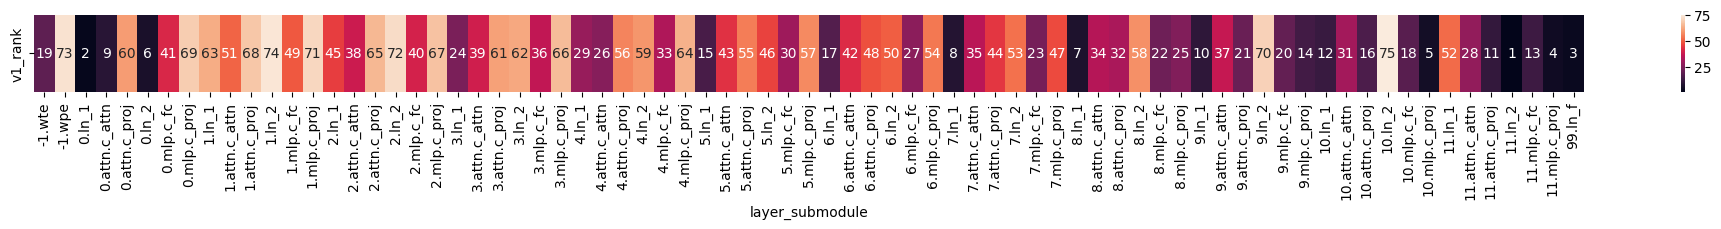

In [87]:
df_temp = df_submodules[["module", "submodule", "layer", "v1_rank"]]
df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
df_temp["layer_submodule"] = df_temp["layer"].astype(str) + "." + df_temp["mod_sub"]

plt.rcParams["figure.figsize"] = (25,1)
df_temp = df_temp.drop(["layer", "mod_sub", "module", "submodule"], axis=1).set_index("layer_submodule").loc[list_layer_submodule_v1].T
sns.heatmap(
    df_temp,
    annot=True
)


#### in

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/3276770328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_39424/3276770328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
/var/folders/_k/vry5m2bj1p7d9f

<Axes: xlabel='layer_submodule'>

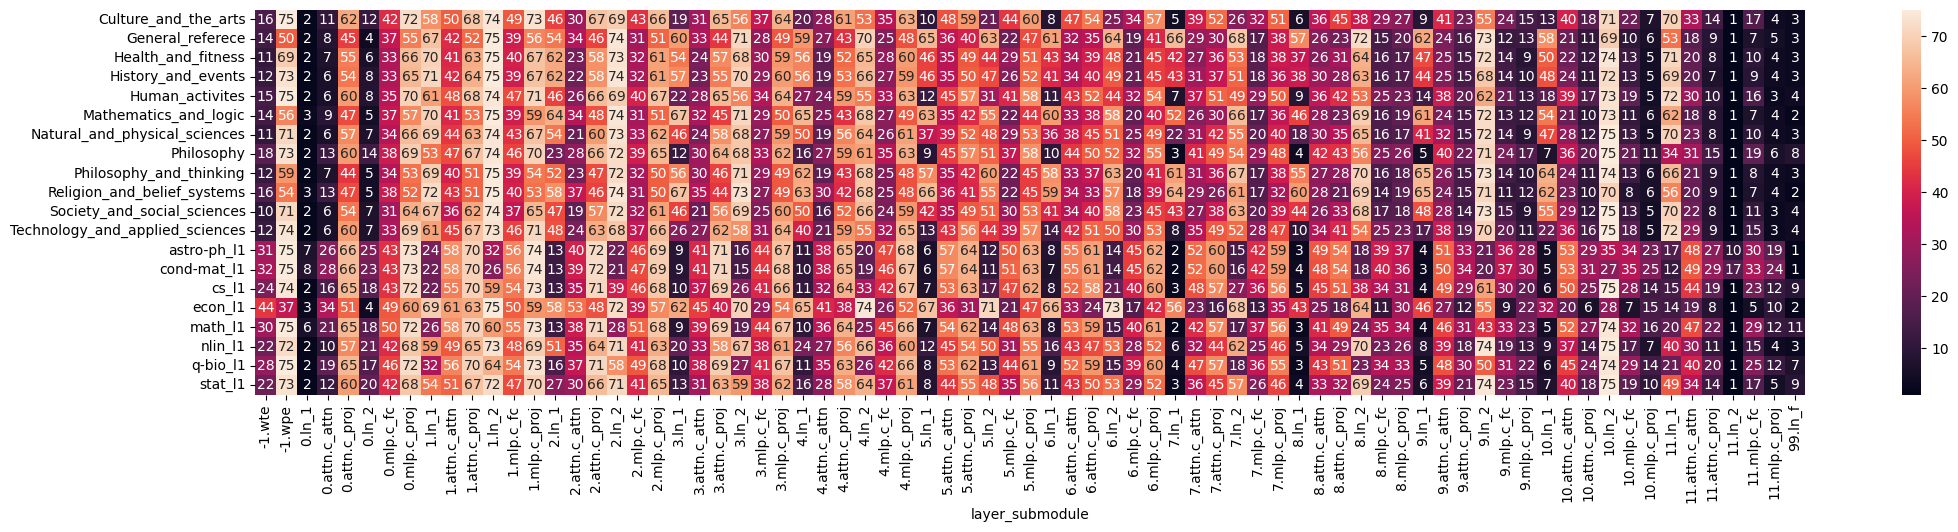

In [88]:
# temp = df_temp.T.index.tolist()
df_temp = df_sub_in_rank[["module", "submodule", "dataset", "layer", "v1_in_rank"]]
df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
df_temp["layer_submodule"] = df_temp["layer"].astype(str) + "." + df_temp["mod_sub"]
df_temp = df_temp.drop(["layer", "mod_sub", "module", "submodule"], axis=1)
df_temp= df_temp.set_index(["layer_submodule", "dataset"]).unstack(-1).loc[list_layer_submodule_v1]
df_temp.columns = [tup[1] for tup in df_temp.columns]

plt.rcParams["figure.figsize"] = (25,5)
sns.heatmap(
    df_temp.T,
    annot=True
)


### v2

In [89]:
list_layer_submodule_v2 = []
for layer in range(0, 12):
    for c in ["attn.c_attn", "attn.c_proj", "mlp.c_fc", "mlp.c_proj"]:
        list_layer_submodule_v2.append(f"{layer}.{c}")

list_layer_submodule_v2 = list_layer_submodule_v2

#### all

<Axes: xlabel='layer_submodule'>

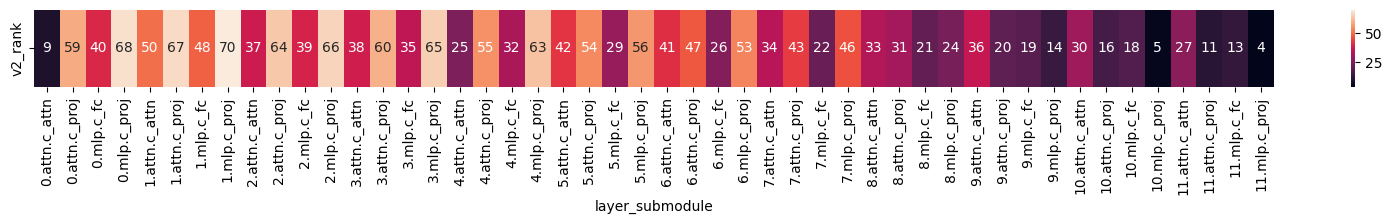

In [90]:
df_temp = df_submodules.loc[df_submodules.is_investigated][["module", "submodule", "layer", "v2_rank"]]
df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
df_temp["layer_submodule"] = df_temp["layer"].astype(str) + "." + df_temp["mod_sub"]

plt.rcParams["figure.figsize"] = (20,1)
df_temp = df_temp.drop(["layer", "mod_sub", "module", "submodule"], axis=1).set_index("layer_submodule").loc[list_layer_submodule_v2].T
sns.heatmap(
    df_temp,
    annot=True
)


#### in

In [91]:
# temp = df_temp.T.index.tolist()
df_temp = df_sub_in_rank.loc[df_sub_in_rank.is_investigated][["module", "submodule", "dataset", "layer", "v2_in_rank"]]
df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
df_temp["layer_submodule"] = df_temp["layer"].astype(str) + "." + df_temp["mod_sub"]
df_temp = df_temp.drop(["layer", "mod_sub", "module", "submodule"], axis=1)
df_temp= df_temp.set_index(["layer_submodule", "dataset"]).unstack(-1).loc[list_layer_submodule_v2]



<Axes: xlabel='layer_submodule'>

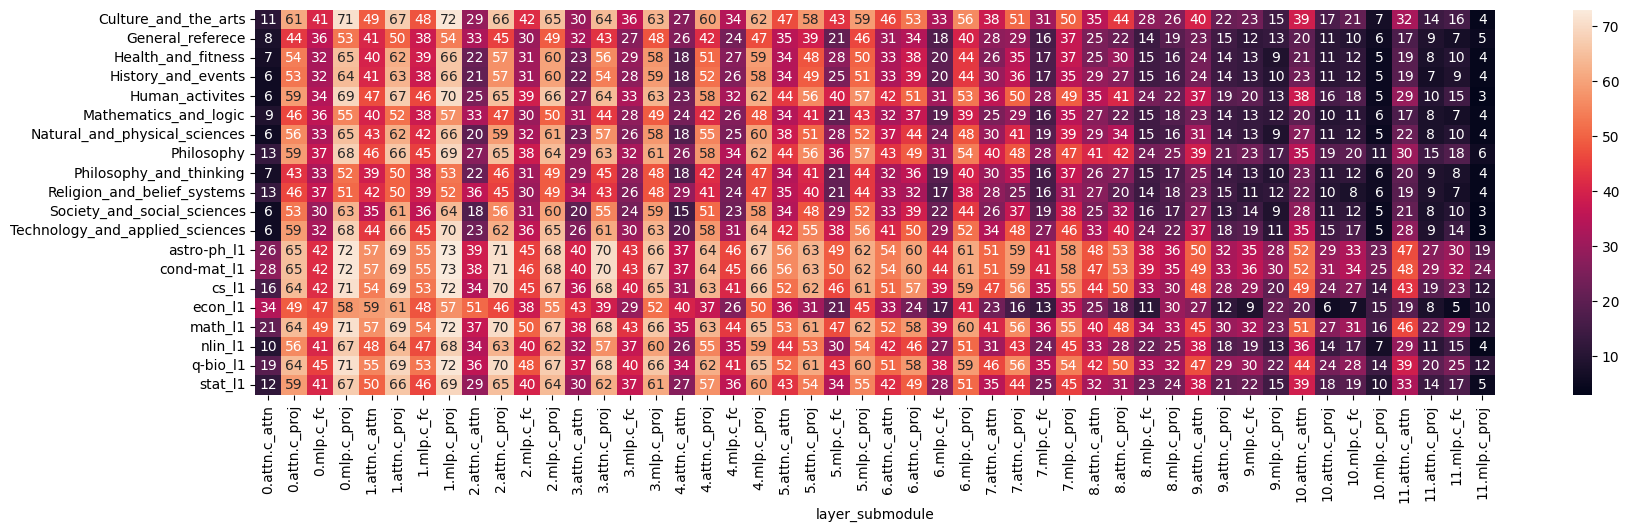

In [92]:

df_temp.columns = [tup[1] for tup in df_temp.columns]

plt.rcParams["figure.figsize"] = (20,5)
sns.heatmap(
    df_temp.T,
    annot=True
)


# Visualisation

### boxplot for the scaled and mean weight- and bias-differences by layers


<Axes: xlabel='layer', ylabel='scaled_diff'>

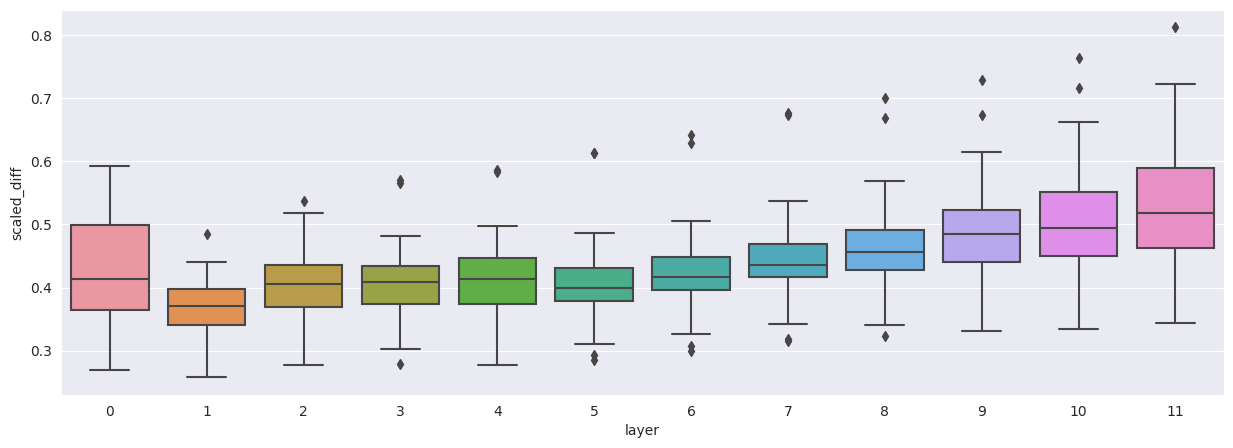

In [91]:
plt.rcParams["figure.figsize"] = (15,5)
# df_avg_diff_weights.layer += 1
sns.boxplot(
#     df_avg_diff_weights,
    df_avg_diff_weights[df_avg_diff_weights.is_investigated],
    x='layer',  y='scaled_diff'
#     , errorbar='se'
)
# df_avg_diff_weights.layer -= 1
# df_avg_diff_weights = df_avg_diff_weights.rename({"scaled difference": "diff_v2"}, axis=1)

<Axes: xlabel='layer', ylabel='scaled_diff'>

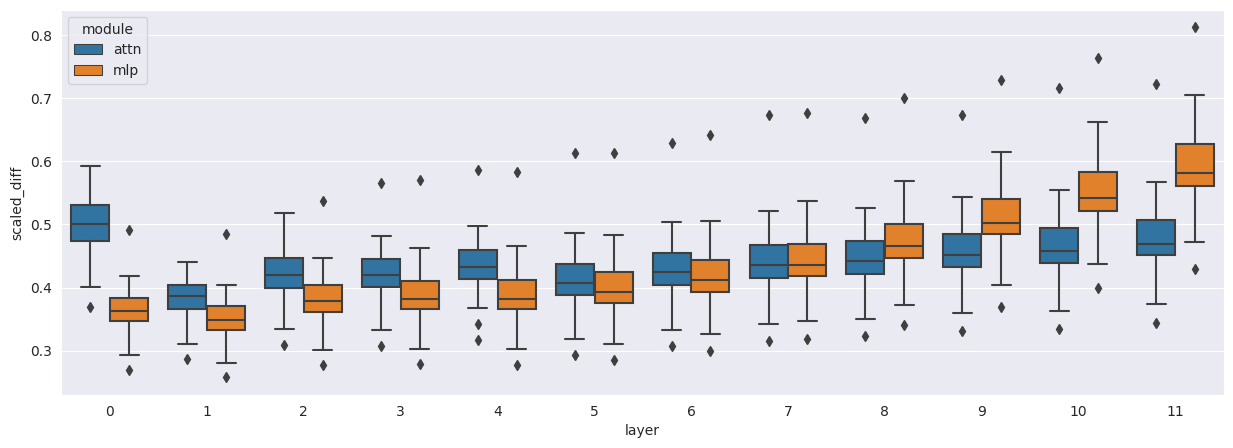

In [46]:
plt.rcParams["figure.figsize"] = (15,5)
# df_avg_diff_weights.layer += 1
sns.boxplot(
#     df_avg_diff_weights,
    df_avg_diff_weights[df_avg_diff_weights.is_investigated],
    x='layer',  y='scaled_diff', hue='module'
#     , errorbar='se'
)
# df_avg_diff_weights.layer -= 1
# df_avg_diff_weights = df_avg_diff_weights.rename({"scaled difference": "diff_v2"}, axis=1)